In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")

setwd("../")
list.files()

[1] "figures"             "input"               "notebooks"          
[4] "source_data"         "supplemental_tables"

### Figure 1b - TF Enrichments

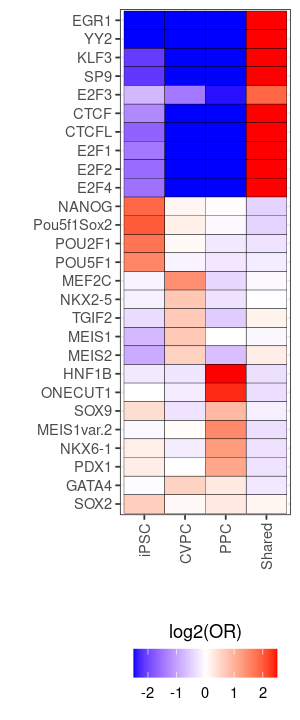

In [3]:
tf_enrichments    = fread("supplemental_tables/Table_S5.txt",sep="\t",data.table=F)
tf_enrichments  = rbind(unique(tf_enrichments %>% filter(Type == "Shared") %>% 
                                        group_by(TF) %>%
                                        mutate(`Odds Ratio` = mean(`Odds Ratio`),
                                               `Adjusted P-value` = mean(`Adjusted P-value`),
                                              Tissue = "Shared") %>%
                                        select(TF, Database, Tissue, Type, `Odds Ratio`, `Adjusted P-value`)),
                        tf_enrichments %>% filter(Type == "Specific") %>% 
                        select(TF, Database, Tissue, Type, `Odds Ratio`, `Adjusted P-value`))


tf_toplot = tf_enrichments %>% filter(Database == "JASPAR" | TF == "NANOG")

tf_toplot = tf_toplot[ tf_toplot$TF %in% c("MEIS2","MEF2C","SOX2","POU5F1","ONECUT1","NKX2-5","NANOG","PDX1","NKX6-1","HNF1B","GATA4","CTCF","EGR1","E2F2","E2F5",
                                                "SOX9","Pou5f1Sox2","E2F4","E2F3","E2F1","MEIS1","TGIF2","MEIS1var.2","KLF3","SP9","YY2","POU2F1","CTCFL"),]

tf_toplot$`log2(OR)` = log2(tf_toplot$`Odds Ratio`)

tf_toplot$`log2(OR)`[ tf_toplot$`log2(OR)` < -2.5 ] = -2.5
tf_toplot$`log2(OR)`[ tf_toplot$`log2(OR)` > 2.5 ] = 2.5
tf_toplot$Tissue = factor(tf_toplot$Tissue , levels = c("iPSC","CVPC","PPC","Shared"))

cast = reshape2::dcast(Tissue ~ TF, data = tf_toplot, fun.aggregate = mean, value.var = "log2(OR)")
rownames(cast) = cast$Tissue
cast$Tissue = NULL

ord = hclust( dist(t(cast), method = "euclidean"), method = "ward.D" )$order
# ord = c(2,10,3,27,1,7,25,3,4,6,5,ord[10:length(ord)])
tf_toplot$TF = factor(tf_toplot$TF, levels = rev(colnames(cast[,ord])))

psize(6,2.5)
fig1b = ggplot(tf_toplot, aes(Tissue, TF, fill= `log2(OR)`)) + theme_bw()+
  geom_tile(color = "black")  + ylab("") + xlab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
         legend.position = "bottom") +
  scale_fill_gradient2(low="blue",mid = "white", high="red") +   
    guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = guide_legend(title.position="top", title.hjust = 0.5))
fig1b

### Figure 1c - LDScore Regression

In [4]:
ldscore = fread("supplemental_tables/Table_S6.txt",sep="\t",data.table=F)

ldscore$lab = gsub("I[0-9]+ ","", ldscore$Trait_Description)
ldscore$lab [ ldscore$Trait_ID == "lifegen_phase2_bothpl_alldr_2017_09_18"] = "Parental Lifespan"
ldscore$lab [ ldscore$Trait_ID == "timmers2020_healthspan_lifespan_longevity"] = "Aging"
ldscore$lab [ ldscore$lab == "Birth Weight (European)"] = "Birth Weight"
ldscore$lab [ ldscore$lab == "LDL Direct"] = "LDL Cholesterol"
ldscore$lab [ ldscore$lab == "Body Mass Index (BMI)"] = "Body Mass Index"
ldscore$lab [ ldscore$lab == "Childhood Obesity (European)"] = "Childhood Obesity"
ldscore$lab [ ldscore$lab == "Chronic Ischemic Heart Disease"] = "Ischemic Heart Disease"
ldscore$lab [ ldscore$lab == "Atrial Fibrillation And Flutter"] = "Atrial Fibrillation"
ldscore$lab [ ldscore$lab == "Acute Myocardial Infarction"] = "Myocardial Infarction"

ldscore$Category = gsub("ChIP", "H3K27ac",ldscore$Category)
ldscore$Enrichment2 = ldscore$Enrichment
ldscore = ldscore[ !ldscore$lab %in% c("Healthspan" ),]

ldscore$Enrichment2[ ldscore$Enrichment2 > 10 ] = 10
ldscore$Enrichment = ifelse(ldscore$Enrichment_p < 0.01, ldscore$Enrichment2, 0)

ld_cast = reshape2::dcast(Category ~ lab, data = ldscore, value.var = "Enrichment", fun.aggregate = mean)
rownames(ld_cast) = ld_cast$Category
ld_cast$Category = NULL

ld_ord <- hclust( dist(t(ld_cast), method = "euclidean"), method = "ward.D" )$order
ldscore$Category = factor(ldscore$Category, levels = rev(c("PPC ATAC-seq","CVPC ATAC-seq","CVPC H3K27ac-seq",
                                                       "iPSC ATAC-seq","iPSC H3K27ac-seq")))

ldscore$lab = factor(ldscore$lab, levels = rev(c("HDL Cholesterol","Fasting Glucose","LDL Cholesterol",
                                            "Myocardial Infarction","Ventricular Rate",
                                            "Atrial Fibrillation","QRS Duration",
                                            "Angina Pectoris","Pulse Rate","Body Mass Index",
                                            "Childhood Obesity","Birth Weight",
                                             "Ischemic Heart Disease","Type 2 Diabetes",
                                            "Aging","Parental Lifespan","Type 1 Diabetes")))


psize(5,4)

fig1c = ggplot(ldscore, aes(lab, Category,  fill= Enrichment)) + theme_bw()+
  geom_tile(color = "black")  + ylab("") + xlab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=10),
         axis.text.y = element_text(size=10),
         legend.position = "bottom") +
  scale_fill_gradient2(low="blue", mid="white", high="red") + coord_flip() +
    guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = guide_legend(title.position="top", title.hjust = 0.5))


In [5]:
psize(5,6)
png("figures/Figure1.png",res=300,units="in",height=5,width=6)
plot_grid(fig1b, NULL, fig1c,
          nrow=1,rel_widths = c(1,0.3,1.5),
         labels =c("b","","c"))
dev.off()

png 
  2

### Figure S5c - Shared

In [2]:
shared_peaks_bed   = as.data.frame(rbindlist(list(fread("input/figure1/ipsc_cvpc.bed",sep="\t",data.table=F)[,c(4,8)],
                                                  fread("input/figure1/ipsc_ppc.bed",sep="\t",data.table=F)[,c(4,8)],
                                                  fread("input/figure1/cvpc_ppc.bed",sep="\t",data.table=F)[,c(4,8)])))
shared_peaks     = unique(c(shared_peaks_bed[[1]],shared_peaks_bed[[2]]))

In [4]:
peaks = rbindlist(list(fread("input/figure1/ipsc_atac_peaks.bed",sep="\t",data.table=F),
                       fread("input/figure1/cvpc_atac_peaks.bed",sep="\t",data.table=F),
                       fread("input/figure1/ppc_atac_peaks.bed",sep="\t",data.table=F)))


      
        FALSE   TRUE
  CVPC  79528 123413
  iPSC  66370 105705
  PPC   65684 127744